# Agent Tools and Configurations

Tools give agents ability to take actions: sequential/parallel calls, error handling, and state persistence.

**What you'll learn:**
- Tools extend agent capabilities with actions
- @wrap_tool_call handles errors gracefully
- Agent selects tools based on docstrings
- Sequential vs parallel execution determined by model
- Clear tool descriptions guide selection

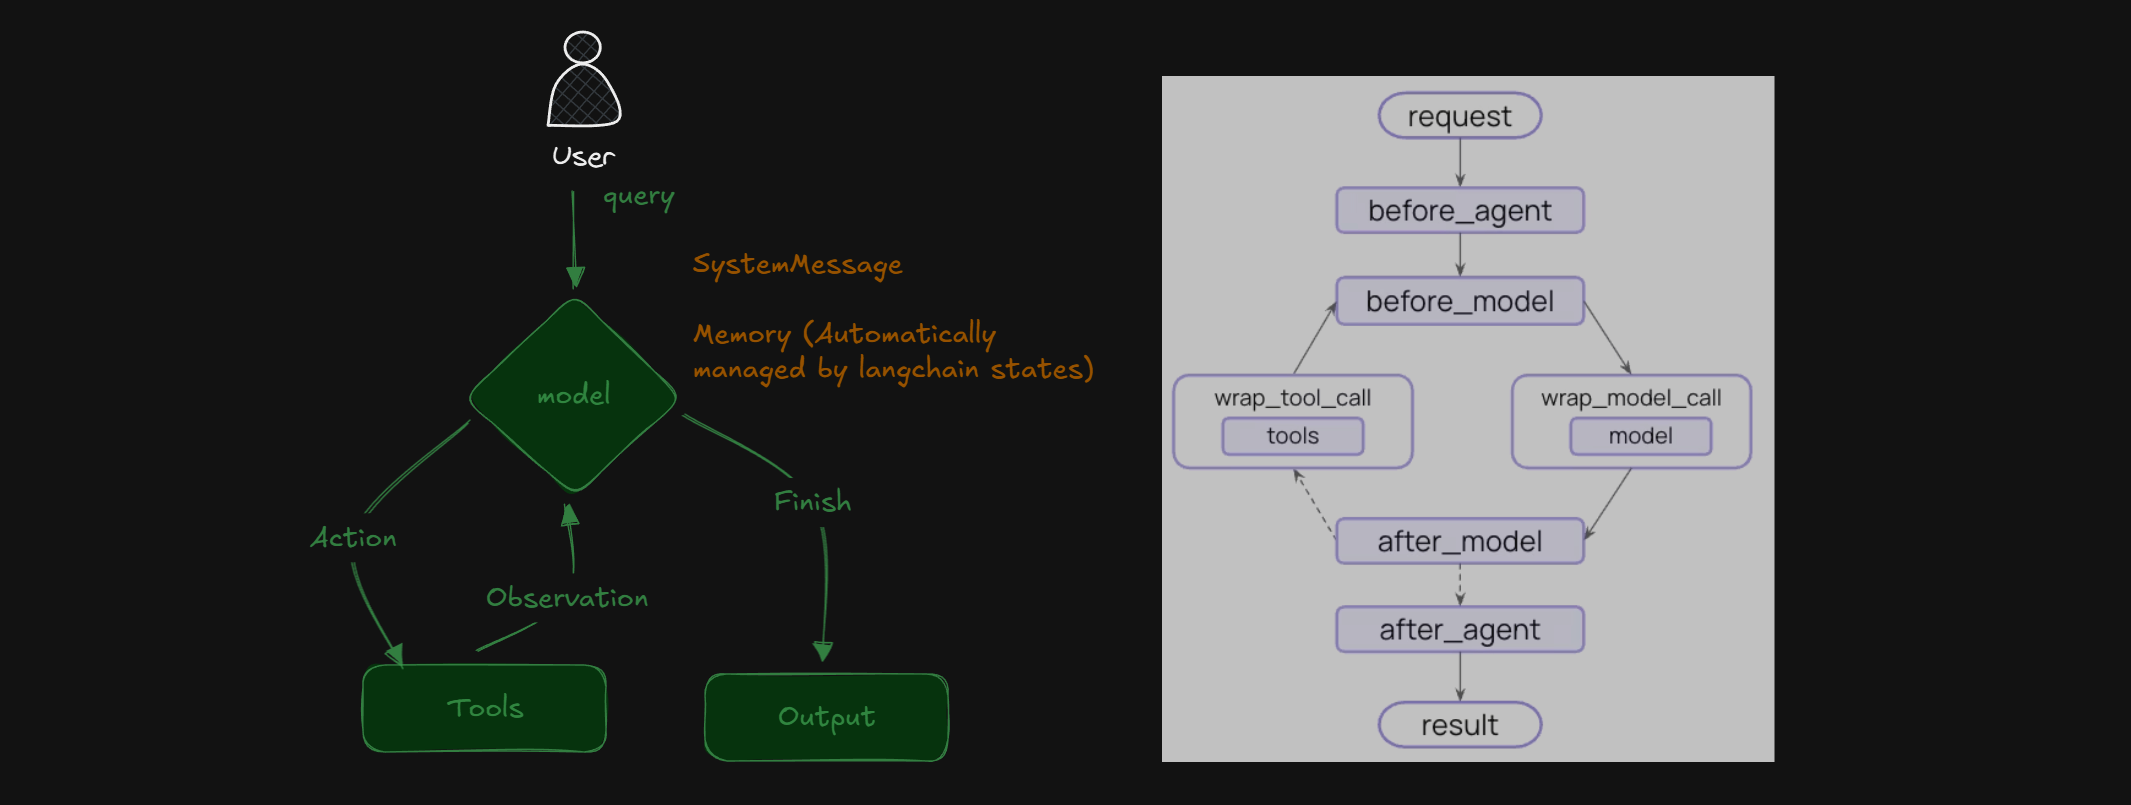

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

import os
from dotenv import load_dotenv
load_dotenv()

from scripts import base_tools

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.agents import create_agent
from langchain.messages import HumanMessage, AIMessage, ToolMessage, SystemMessage

model = ChatGoogleGenerativeAI(model='gemini-2.5-flash')

In [3]:
base_tools.web_search

StructuredTool(name='web_search', description='Perform a live web search using Ollama Cloud Web Search API for real-time information and news.\n\nInput:\n    query: search query string\n\nOutput:\n    JSON string of top results (max_results=2).', args_schema=<class 'langchain_core.utils.pydantic.web_search'>, func=<function web_search at 0x0000023CCF6AB740>)

In [4]:
base_tools.web_search

StructuredTool(name='web_search', description='Perform a live web search using Ollama Cloud Web Search API for real-time information and news.\n\nInput:\n    query: search query string\n\nOutput:\n    JSON string of top results (max_results=2).', args_schema=<class 'langchain_core.utils.pydantic.web_search'>, func=<function web_search at 0x0000023CCF6AB740>)

In [5]:
# response = base_tools.web_search.invoke('kgp talkie')

response = base_tools.web_search.invoke({'query': 'kgp talkie'})

In [6]:
response


[WebSearchResult(content='# Free Machine Learning\n\n[Machine Learning] [**How to Become a Successful Machine Learning Engineer**]\n\nMachine learning is a rapidly growing field that offers a wide range of opportunities for those who have the right skills and qualifications. As a machine learning engineer, you will be responsible for designing and implementing machine learning models that...\n\n[Read more]\n\n[Machine Learning] [**Interview Questions and Answers on TF-IDF in NLP and Machine Learning**]\n\nWhat is TFIDF? TF-IDF, short for term frequency-inverse document frequency, is a numerical statistic that is used to reflect how important a word is to a document in a corpus of documents. It is commonly used in natural language processing...\n\n[Read more]\n\n[Machine Learning] [**Top 10 Interview Questions and Answers for MLOps Engineers**]\n\nMLOps, or Machine Learning Operations, is the practice of combining machine learning and operations to enable the rapid, reliable, and secure

In [7]:
# base_tools.web_search({'query': 'kgp talkie'}) # < don't call it in this way

## Basic Agent with Tools

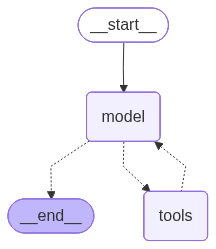

In [8]:
agent = create_agent(model=model,
                     tools=[base_tools.web_search, base_tools.get_weather],
                     system_prompt='You are a helpful AI assistant.'
                     )

agent

In [9]:
query = 'what is the current weather in Mumbai?'
response = agent.invoke({'messages': [HumanMessage(query)]})
response

{'messages': [HumanMessage(content='what is the current weather in Mumbai?', additional_kwargs={}, response_metadata={}, id='909fa343-7315-4a02-987d-a5201100db9a'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"location": "Mumbai"}'}, '__gemini_function_call_thought_signatures__': {'b23bf456-d78a-4060-8077-0069bb73257d': 'CqICAXLI2nxZcUfIIi3a8AjDxtdJkcdAy13YaAqjLEcxsepF3a9vXWLOI+i7w083/E410aCFGjLQAh9e0yylLECb5y2uGSdaNuJ5Jys2CGtn66rm9zx5yT784DwupFHb4L9t0kHKyqQ3kZf2sucvo9H67hWDOqpMgiWtIxwMZlTi2JyuIHT/HbiwvdHGaRzUByfWXl081PRf6ZvMirSGGRLhRmB5Ez8liEfuH81g55YjZryxNLCMOeQX8zdmY9TDEDabcdnAkkUZqQjYwZaxm1HAbG3GDGDSOmfOqIHMHYsBYbyyzvauvaxJBBQABvEyWsHZKvem811I5/PJSQiARuqA0utEuQKkgXMIm/p5iBptSdhKOYHKn4q4qvEIZ1hfMP8jPNU='}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bbb26-6969-74e2-8688-da9d121c6d9c-0', tool_calls=[{'name': 'get_weather', '

In [10]:
query = 'Tell me news about the Apple stock'
response = agent.invoke({'messages': [HumanMessage(query)]})
response

{'messages': [HumanMessage(content='Tell me news about the Apple stock', additional_kwargs={}, response_metadata={}, id='75f2adec-d488-4317-bab6-cf209e09bfef'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'web_search', 'arguments': '{"query": "Apple stock news"}'}, '__gemini_function_call_thought_signatures__': {'26d6d1ff-ec49-43a8-9cb0-7ab4c6b9e5d2': 'CuIBAXLI2nx8llUk/lecpoondxkaSwiM4XYrBdA5xFZg0DxYec0gY+twEg3bvEVBwKKhan57GYw+fZIEooJ+eIkvkRV5a5O64KagBFlZikSV8f6sn6wSaSLYrwDDG23D7BFKQDJvAwYpy6NganLeDLSwWlYB1CE3iYZjBoZYGbCmoUt4H1Nb0I9DZRFnLutsTTfx2ofpZ6NvIIetsSZPrWLmZpC9dtoY7ZgM4/l+MC/JKufKUFUWzvTYBYGSk9LE2CAW7TZNDBVF8KBpXKIxKUquvvtj6PmTiTZ/kjvwnUOT9ioc1w=='}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bbb26-74cb-7c40-a2ce-aa4d8a5c71d7-0', tool_calls=[{'name': 'web_search', 'args': {'query': 'Apple stock news'}, 'id': '26d6d1ff-ec49-43a8-9cb0-7ab4c6b9e5d2',

## Sequential Tool Calls

In [11]:
query = 'Tell me news about the Apple stock then tell me weather in Mumbai'
response = agent.invoke({'messages': [HumanMessage(query)]})
response

{'messages': [HumanMessage(content='Tell me news about the Apple stock then tell me weather in Mumbai', additional_kwargs={}, response_metadata={}, id='ae59b5e6-bc86-4f72-98d8-911f2d1eb1ee'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'web_search', 'arguments': '{"query": "Apple stock news"}'}, '__gemini_function_call_thought_signatures__': {'f4f37c09-9510-4de9-b793-54909f618bf8': 'CskCAXLI2nwv/yb06NsI3z+fGa8zdqYbMpOD/X66KYGQ/9WoT790ZIkCWhC1/CtlyR6UWAPLY/2+6/Jvy+z7VPC/9BZ94BnHKF+dQU5jmNPIrKMxRAbJ0nxCA76VnFtgQmOfAxq3Apgl5hqDEem2XaNgqjhWG3LiAC2I7Akb3t5jXH+0WbyovsSMht07M7AYquyA9gro25fez1gs3kY4gOeJ11Rd0TJIwPtQFcb+75F9e7rnmbPos3qf4LAL1TPQsXpxkocbQYT8YrVdrl4lTnTZN/9jZRuBo/+L3Lyd+JEpuZL82cnDY4jpfW+LIzFZlWPowiCMLaGOvkqwEutGIHsUuJlkef4RySYV+opG25eWPuwGADS6KgkzBF/WkGkzWTfEWp54dBA8dHoHwnxu8AuKL3GC0Yx8K/kwdTUSErTc1o9YSaxpBkDH8F0='}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='l

## Parallel Tool Calls

In [12]:
query = 'Tell me news about the Apple stock also tell me weather in Mumbai'
response = agent.invoke({'messages': [HumanMessage(query)]})
response

{'messages': [HumanMessage(content='Tell me news about the Apple stock also tell me weather in Mumbai', additional_kwargs={}, response_metadata={}, id='61676ecc-be1e-4f7e-a289-c6dc948c7492'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"location": "Mumbai"}'}, '__gemini_function_call_thought_signatures__': {'3a57a8c8-aa3d-4326-aa49-663b54508598': 'Cs0CAXLI2nwlNJb+wEsGWk1SfY17t7QiOumMK3mnEb8nyL8Gf5nQO7kYojm5xjx9f66tIcwVpz2jxi5soGCCL0m1paYN4od6lZVEAZiJn3CUTBj2Q41FpNQkmoBzCFqpXUb95TWVKdh+voP84cJzZjYuXDVvVCf6m6JT+Y7CyGAinsFkWeZKrGGMFYE557Mm3gAoBni88RSLunHLEA4w+uxM11L+v7S4Dqhiw9s5gbSxVd/C2S2QKsakXjNs1nFctrm+RLr7pkOKXk0CYU+jla1c7PChEH/KHoaizwuckvSm3sy5WsIhVM/P3n/9WIoXLGeRNDubA4yg09Gnb2CqKMT/Ki5adpNzP7TIJ2QjXgGJn4TrMViZmvJivs8QpKg8PO+FpMp4o8XHVEsgxZCZuMX+r9q4gIXDQw6H/PrXeduKJqhZnrX3ir2iGGnO/8aS'}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_

## Tool Error Handling

In [19]:
from langchain.tools import tool
from langchain.agents.middleware import wrap_tool_call

@tool
def divide(a:float, b:float):
    """Divide the two numbers"""
    return a/b

@wrap_tool_call
def handle_tool_errors(request, handler):
    try:
        return handler(request)
    except Exception as e:
        return ToolMessage(
            content=f"Error: {str(e)}. Try different Input.",
            tool_call_id = request.tool_call['id']
        )


agent = create_agent(model=model,
                     tools=[base_tools.web_search, base_tools.get_weather, divide],
                     system_prompt='You are a helpful AI assistant.',
                     middleware=[handle_tool_errors]
                     )

query = 'what is the current weather in Mumbai and what is 1/0?'
response = agent.invoke({'messages': [HumanMessage(query)]})
response

{'messages': [HumanMessage(content='what is the current weather in Mumbai and what is 1/0?', additional_kwargs={}, response_metadata={}, id='1c5ddcfc-7cdb-493c-8f85-e49107d20fdf'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"location": "Mumbai"}'}, '__gemini_function_call_thought_signatures__': {'fe086be2-d1ba-43e3-8228-70bdc3990829': 'CpkEAXLI2nzpCxG07XY5uYNvlO2ltAP9dSBWsJxSo0UhQGLVn9788CncEnOZ94TEQiHw8FXgYingDTSIfTwlfXC451uH44I+wWnGAPUWi26LcpjK75aUWaJOA3xf4QiY722RHB0XpGDiDbG8RfEXVi/2LQERwN3CdcVWEb5ess0Yky+am322XJk9dlP1ibyH2cjEGvbnS480smyyKYylOvA/paBcBt4lnF85kMXH6RllBse+vobH9b11WiUwfio7I4Fl7QQwktGCzpQtKeXkOgLbW73ZAJC/E+VfXco6qzzilGnAg3M/jgXpJWc31eGwtt+MtqLu+i5a+RhXCsm+oCwOl38h6lFwWZsjESRXVk5XXIPQereLyWaxMU+4TvCwjGP7Dvhw3+XO49FqNgQkGJsTizsHvgqIHsHOS4+O4+Td+nIUegiMXshd5RiwHqlrjnckra7uzL+SUWn+D0d5UwhDxfNy2fKlaVOtN6mgZuhCbNb2o0H71JENButlyE27fQX4cR26dfaxKF/zQ8mT5IXQOt9DUzQsqb9QJOKgXgGozm4zZUo9MAG1edvpirt6AKkev/RmnenaspwFoUiQbkmNXkpRRi

## Accessing Context - State Access

In [28]:
from langchain.tools import ToolRuntime
from dataclasses import dataclass

@tool
def get_message_count(runtime: ToolRuntime):
    """Get the total number of messages exchanged in the conversation."""

    messages = runtime.state['messages']
    context = runtime.context

    return f"User '{context.user_id}' with Session ID '{context.session_id}' history have '{len(messages)}' messages."


# context is immutable
@dataclass
class UserContext:
    user_id: str
    session_id: str


agent = create_agent(model=model,
                     tools=[base_tools.web_search, base_tools.get_weather, divide, get_message_count],
                     system_prompt='You are a helpful AI assistant.',
                     middleware=[handle_tool_errors],
                     context_schema=UserContext
                     )


query = 'what is the current weather in Mumbai there after tell me How many messages are there in the current conversation'
user_context = UserContext(user_id='kgptalkie', session_id='session_1')

response = agent.invoke({'messages': [HumanMessage(query)]}, 
                        context=user_context)


In [29]:
response

{'messages': [HumanMessage(content='what is the current weather in Mumbai there after tell me How many messages are there in the current conversation', additional_kwargs={}, response_metadata={}, id='cf524990-1bb1-4038-b279-297b04ab02d0'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"location": "Mumbai"}'}, '__gemini_function_call_thought_signatures__': {'6b8b5f8c-e983-4440-98b1-e1692b100c90': 'CrUCAXLI2ny4HBl92btytyYbf32C0DWUVwAODTrcoYWal+M8bBYf3B7QZsoOrc0wVnJncnghaVtjMuRYs3mB/4YZ0EWUE9eSzso8IGDm/5HsRs1RBCd+Jh+FF+W8AusNWc5QKeC0itU2Yk2QfJ0lTEbsWPxfOH354sg29HPSYKX622oViKIcXq/GEm47jn3qi3s0Xg5lyVVKJgtv5jSveKhOp8eUVZxJhMqxBR8FEsWagqRIzAgP/zIZhJPPAZL5ssANjuL5MFnDSqA20Hl7gFA5YsBEIbgm+9kbF599qh4TsH5m1jgIBdrxN2ksSqh46ZxAiprrbg3ihZvSxMPU2/AknMn1vqr8c41iJmtk4Gc/MtH7Rlb97z2MnYIXhBUNcfE31jXDyiMeX7Ls2i3oa4DyqOe20h6T'}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_